In [1]:
import os
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras import Sequential
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers


In [2]:
data_dir = 'D:/programming/College/Deep Learning/project/55_classes'
corrupted_images = []
def preprocess_image(image_path):
    try:
        image = cv2.imread(image_path)
        if image is None:
            corrupted_images.append(image_path)
            return None
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (80,80))
        return image
    except Exception as e:
        corrupted_images.append(image_path)
        return None



In [3]:
def load_artist_data_as_dataframe(data_dir):
    data = []
    label_map = {}
    for idx, folder in enumerate(os.listdir(data_dir)):
        if folder.startswith("pins_"):
            artist_name = folder.split('_', 1)[1]
            label_map[idx] = artist_name
            folder_path = os.path.join(data_dir, folder)
            for file in os.listdir(folder_path):
                if file.endswith(('.jpg', '.jpeg', '.png')):
                    file_path = os.path.join(folder_path, file)
                    image = preprocess_image(file_path)
                    if image is not None:
                        data.append({
                            "image_array": image,
                            "image_path": file_path,
                            "label": idx,
                            "artist_name": artist_name
                        })
    df = pd.DataFrame(data)
    return df, label_map

In [4]:
df, label_map = load_artist_data_as_dataframe(data_dir)
df = df.groupby('label').filter(lambda x: len(x) >= 2)

In [5]:
def augment_image(image_array):
    augmenter = Sequential([])
    return augmenter.augment_image(image_array)


In [6]:
augmented_data = []
for label, group in df.groupby('label'):
    if len(group) < 5:
        num_to_add = 5 - len(group)
        for _, row in group.iterrows():
            for _ in range(num_to_add):
                augmented_image = augment_image((row['image_array'] * 255).astype(np.uint8)).astype(np.float32) / 255.0
                augmented_data.append({
                    "image_array": augmented_image[..., np.newaxis],
                    "image_path": row['image_path'],
                    "label": row['label'],
                    "artist_name": row['artist_name']
                })
df = pd.concat([df, pd.DataFrame(augmented_data)], ignore_index=True)


In [39]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42, shuffle=True)
print(f"Number of Images: {len(df)}")
print(f"Number of Training Images: {len(train_df)}")
print(f"Number of Testing Images: {len(test_df)}")
print("Celebrity Name:", label_map)


Number of Images: 9160
Number of Training Images: 7328
Number of Testing Images: 1832
Celebrity Name: {0: 'Alexandra Daddario', 1: 'alycia dabnem carey', 2: 'Amanda Crew', 3: 'Andy Samberg', 4: 'Anthony Mackie', 5: 'barack obama', 6: 'Ben Affleck', 7: 'Bill Gates', 8: 'Bobby Morley', 9: 'Brenton Thwaites', 10: 'camila mendes', 11: 'Chris Evans', 12: 'Chris Hemsworth', 13: 'Christian Bale', 14: 'Cristiano Ronaldo', 15: 'Danielle Panabaker', 16: 'Eliza Taylor', 17: 'elizabeth olsen', 18: 'elon musk', 19: 'Emilia Clarke', 20: 'Emma Stone', 21: 'grant gustin', 22: 'Henry Cavil', 23: 'Hugh Jackman', 24: 'Inbar Lavi', 25: 'Irina Shayk', 26: 'Jake Mcdorman', 27: 'Jason Momoa', 28: 'Jennifer Lawrence', 29: 'Jeremy Renner', 30: 'Josh Radnor', 31: 'Katharine Mcphee', 32: 'Katherine Langford', 33: 'kiernen shipka', 34: 'Leonardo DiCaprio', 35: 'Lindsey Morgan', 36: 'Logan Lerman', 37: 'Marie Avgeropoulos', 38: 'melissa fumero', 39: 'Nadia Hilker', 40: 'Neil Patrick Harris', 41: 'Rami Malek', 42: 

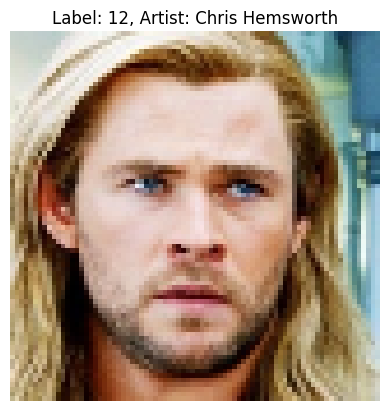

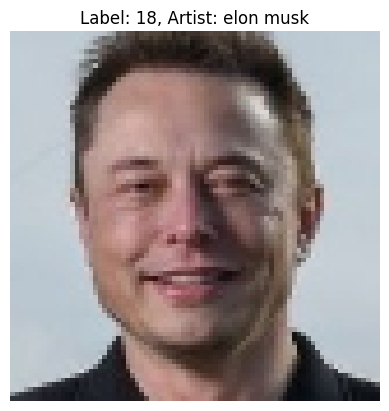

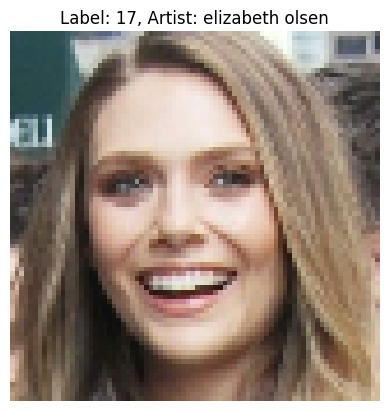

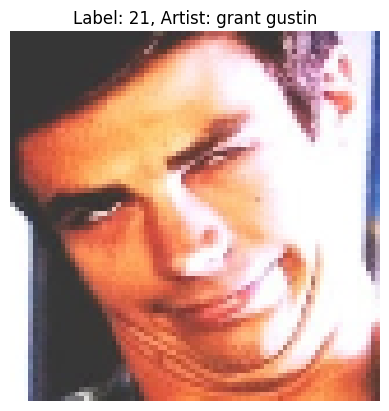

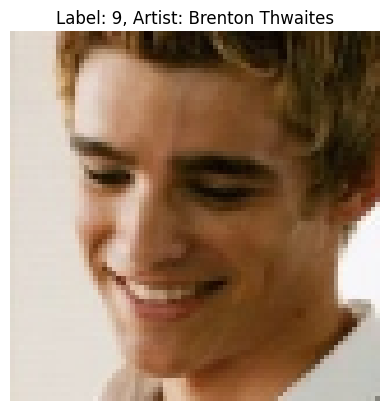

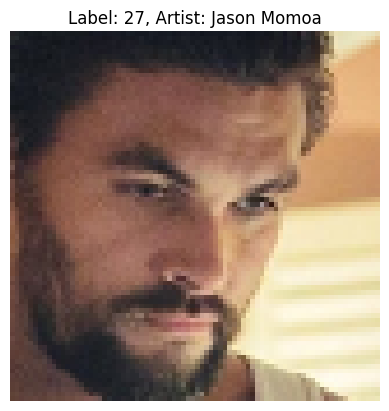

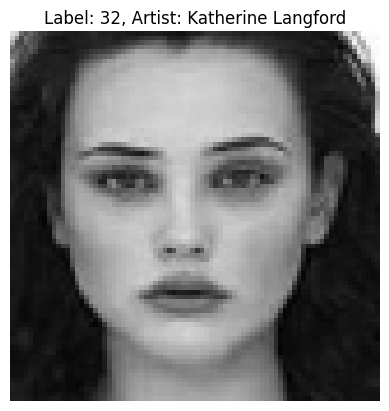

In [ ]:
for i in range(5, 25, 3):
    sample = train_df.iloc[i]
    plt.imshow(sample['image_array'], cmap='gray')
    plt.title(f"Label: {sample['label']}, Artist: {sample['artist_name']}")
    plt.axis('off')
    plt.show()


C:\Users\Dell\AppData\Local\Temp\ipykernel_6812\1852811769.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=artist_counts.index, y=artist_counts.values, palette="viridis")


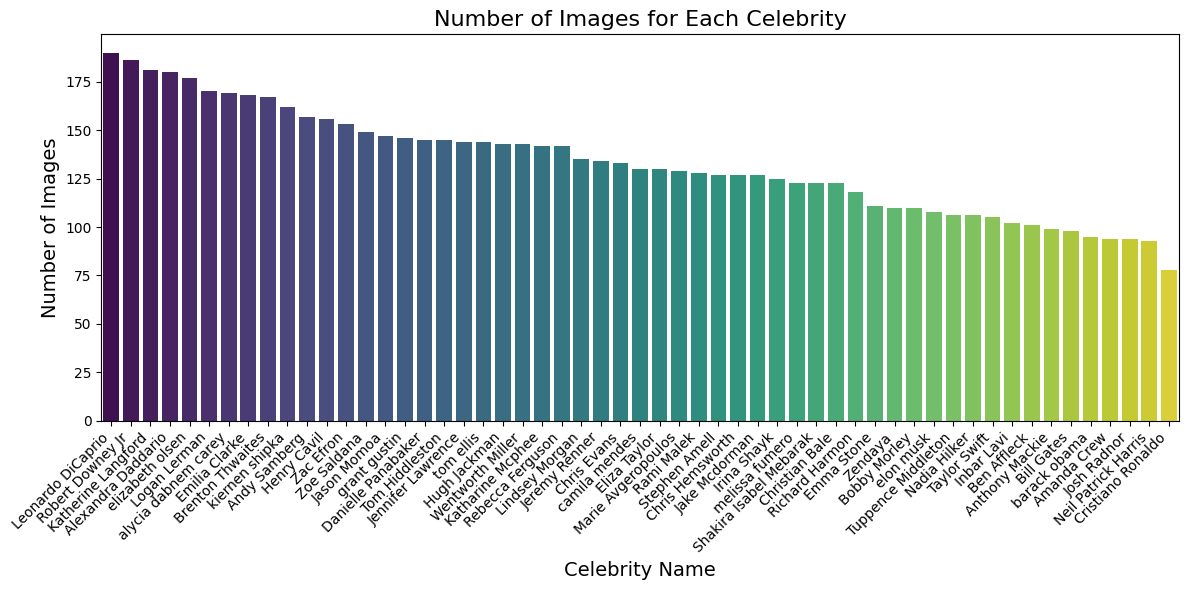

In [38]:
artist_counts = train_df['artist_name'].value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x=artist_counts.index, y=artist_counts.values, palette="viridis")
plt.title("Number of Images for Each Celebrity", fontsize=16)
plt.xlabel("Celebrity Name", fontsize=14)
plt.ylabel("Number of Images", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [41]:
X_train = np.stack(train_df['image_array'].values)
y_train = train_df['label'].values
X_test = np.stack(test_df['image_array'].values)
y_test = test_df['label'].values
print(f"Training Data Shape: {X_train.shape}, Lables Shape: {y_train.shape}")
print(f"Testing Data Shape: {X_test.shape}, Lables Shape: {y_test.shape}")

Training Data Shape: (7328, 80, 80, 3), Lables Shape: (7328,)
Testing Data Shape: (1832, 80, 80, 3), Lables Shape: (1832,)


In [11]:


def residual_block(x, filters, stride=1, downsample=False):
    shortcut = x
    x = layers.Conv2D(filters, kernel_size=3, strides=stride, padding="same", use_bias=False,kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, kernel_size=3, strides=1, padding="same", use_bias=False,kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    if downsample:
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, padding="same", use_bias=False,
                                 kernel_regularizer=tf.keras.regularizers.l2(0.001))(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

In [12]:
def build_resnet50(input_shape=(100, 100, 3), num_classes=10):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, kernel_size=10, strides=2, padding="same", use_bias=False,
                      kernel_regularizer=regularizers.l2(0.001))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding="same")(x)
    for _ in range(3):
        x = residual_block(x, filters=64)
    x = residual_block(x, filters=128, stride=2, downsample=True)
    for _ in range(3):
        x = residual_block(x, filters=128)
    x = residual_block(x, filters=256, stride=2, downsample=True)
    for _ in range(5):
        x = residual_block(x, filters=256)
    x = residual_block(x, filters=512, stride=2, downsample=True)
    for _ in range(2):
        x = residual_block(x, filters=512)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = models.Model(inputs, outputs)
    return model

In [ ]:
num_classes = len(df['artist_name'].unique())
model = build_resnet50(input_shape=(80,80,3), num_classes=num_classes)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 80, 80, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 40, 40,    │     19,200 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 40, 40,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 40, 40,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 20, 20,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 20, 20,    │     36,864 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 20,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 20, 20,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 20, 20,    │     36,864 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 20,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 20, 20,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 20, 20,    │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 20, 20,    │     36,864 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 20,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 20, 20,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 20, 20,    │     36,864 │ re_lu_3[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 20,    │        256 │ conv2d_4[0][0]  

 Total params: 21,339,703 (81.40 MB)

 Trainable params: 21,322,679 (81.34 MB)

 Non-trainable params: 17,024 (66.50 KB)

In [14]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [15]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.5)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25, batch_size=16, callbacks=[early_stopping,reduce_lr])

Epoch 1/25
458/458 ━━━━━━━━━━━━━━━━━━━━ 246s 501ms/step - accuracy: 0.0341 - loss: 11.1819 - val_accuracy: 0.0486 - val_loss: 6.5101 - learning_rate: 0.0010
Epoch 2/25
458/458 ━━━━━━━━━━━━━━━━━━━━ 224s 490ms/step - accuracy: 0.0829 - loss: 5.8093 - val_accuracy: 0.0781 - val_loss: 4.9209 - learning_rate: 0.0010
Epoch 3/25
458/458 ━━━━━━━━━━━━━━━━━━━━ 209s 456ms/step - accuracy: 0.1023 - loss: 4.6693 - val_accuracy: 0.1130 - val_loss: 4.3958 - learning_rate: 0.0010
Epoch 4/25
458/458 ━━━━━━━━━━━━━━━━━━━━ 206s 451ms/step - accuracy: 0.1479 - loss: 4.2188 - val_accuracy: 0.0742 - val_loss: 4.7621 - learning_rate: 0.0010
Epoch 5/25
458/458 ━━━━━━━━━━━━━━━━━━━━ 209s 456ms/step - accuracy: 0.1737 - loss: 4.0336 - val_accuracy: 0.1474 - val_loss: 4.1000 - learning_rate: 0.0010
Epoch 6/25
458/458 ━━━━━━━━━━━━━━━━━━━━ 208s 453ms/step - accuracy: 0.2134 - loss: 3.8024 - val_accuracy: 0.1709 - val_loss: 4.1034 - learning_rate: 0.0010
Epoch 7/25
458/458 ━━━━━━━━━━━━━━━━━━━━ 209s 456ms/step - accur

In [29]:
train_loss12, train_accuracy12 = model.evaluate(X_train, y_train)
print(f"Loss: {train_loss12}, Accuracy: {int(train_accuracy12*100)}%")

229/229 ━━━━━━━━━━━━━━━━━━━━ 31s 133ms/step - accuracy: 0.6641 - loss: 2.3647
Loss: 2.3518757820129395, Accuracy: 66%


In [30]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Loss: {test_loss}, Accuracy: {int(test_accuracy*100)}%")

58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step - accuracy: 0.4736 - loss: 3.1760
Loss: 3.1567206382751465, Accuracy: 47%


In [31]:
model.save("resnet50_grayscale_artists_with_dropout_and_regularization4.h5")
model.save("resnet50_grayscale_artists_with_dropout_and_regularization4.keras")

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step


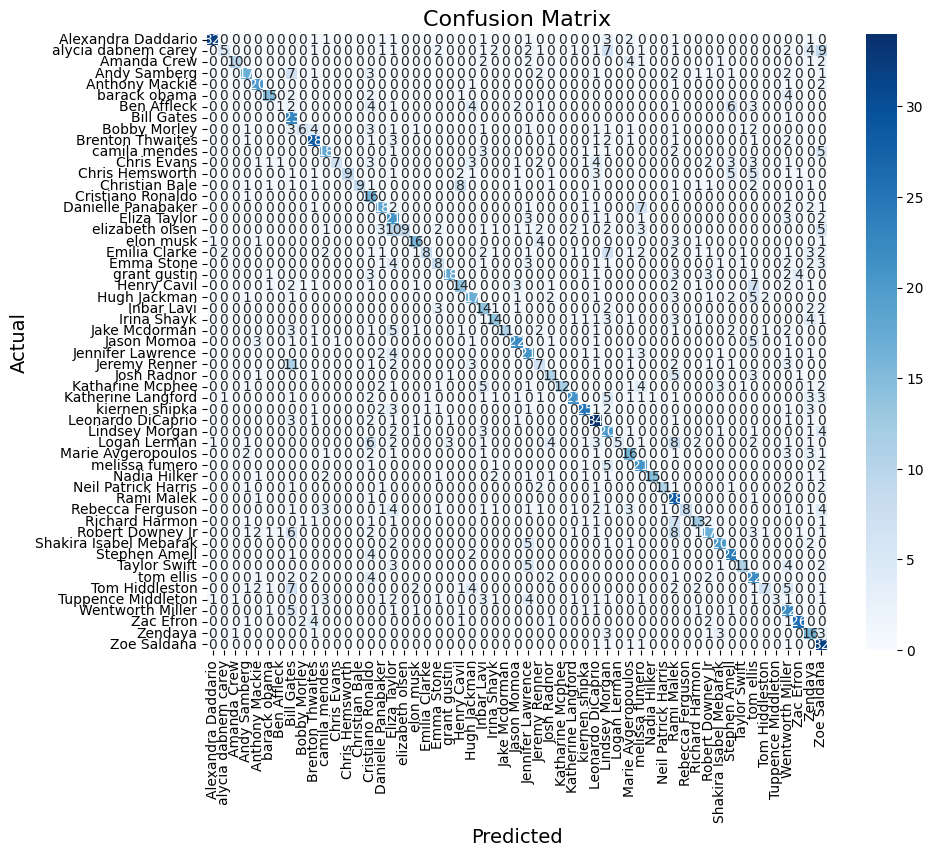

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.values(), yticklabels=label_map.values())
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("Actual", fontsize=14)
plt.show()

In [21]:
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=label_map.values()))

Classification Report:
                        precision    recall  f1-score   support

    Alexandra Daddario       0.91      0.71      0.80        45
   alycia dabnem carey       0.62      0.12      0.20        42
           Amanda Crew       0.83      0.43      0.57        23
          Andy Samberg       0.55      0.44      0.49        39
        Anthony Mackie       0.61      0.80      0.69        25
          barack obama       0.68      0.62      0.65        24
           Ben Affleck       0.33      0.04      0.07        25
            Bill Gates       0.27      0.96      0.43        24
          Bobby Morley       0.60      0.21      0.32        28
      Brenton Thwaites       0.53      0.67      0.59        42
         camila mendes       0.58      0.56      0.57        32
           Chris Evans       0.88      0.21      0.34        33
       Chris Hemsworth       1.00      0.28      0.44        32
        Christian Bale       1.00      0.29      0.45        31
     Cristiano R

In [22]:
y_test_ohe = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

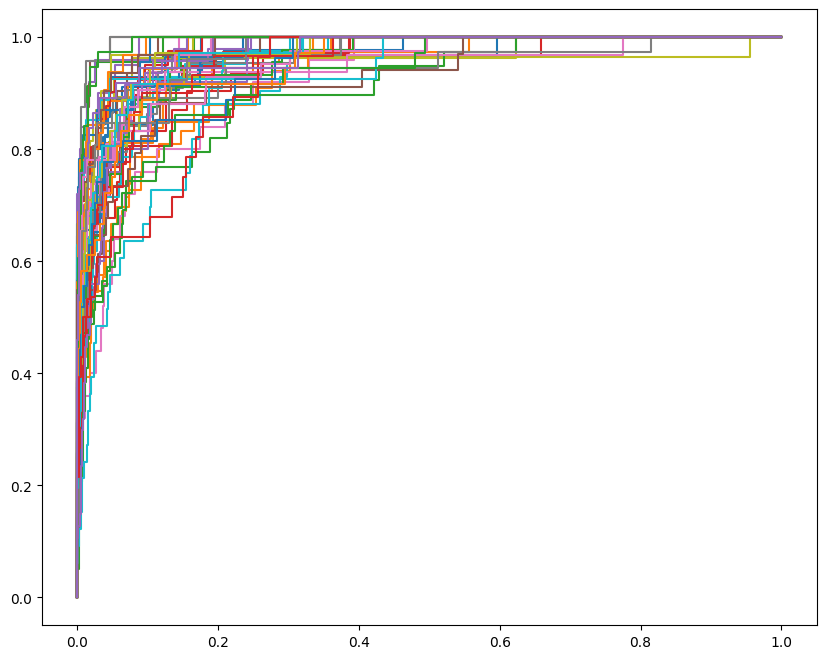

In [ ]:
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test_ohe[:, i], y_pred_probs[:, i])
    auc_score = roc_auc_score(y_test_ohe[:, i], y_pred_probs[:, i])
    plt.plot(fpr, tpr, label=f"Class {label_map[i]} (AUC = {auc_score:.2f})")

C:\Users\Dell\AppData\Local\Temp\ipykernel_6812\4231223477.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="lower right", fontsize=12)


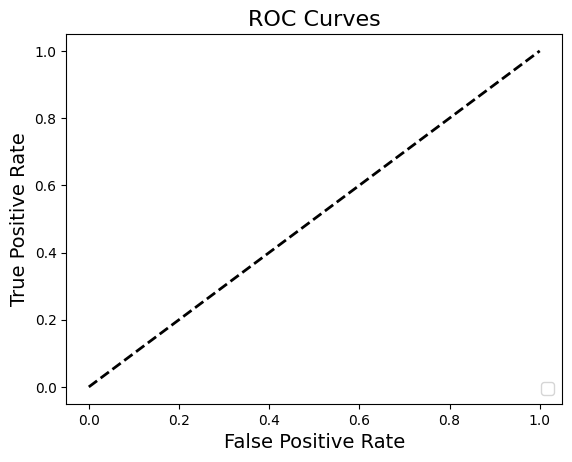

In [24]:
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.title("ROC Curves", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.show()

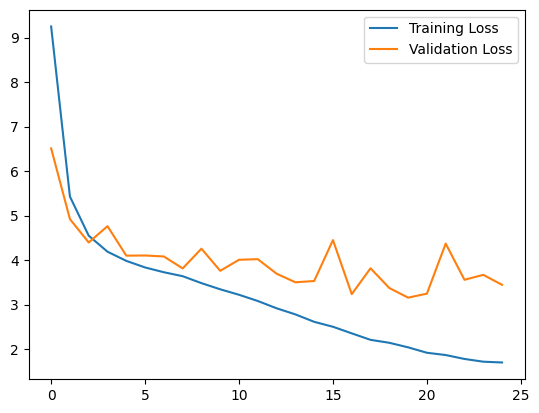

In [25]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

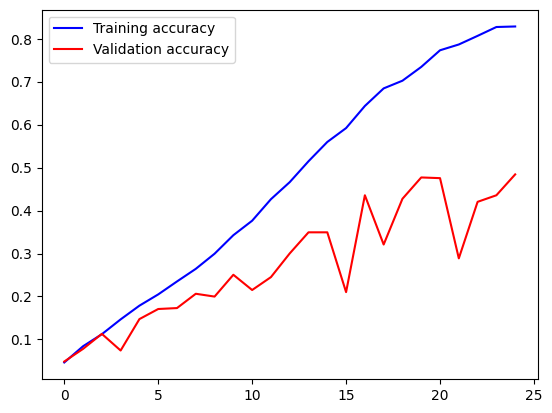

In [ ]:
plt.plot(history.history['accuracy'], color='b', label="Training accuracy")
plt.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
plt.legend()
plt.show()

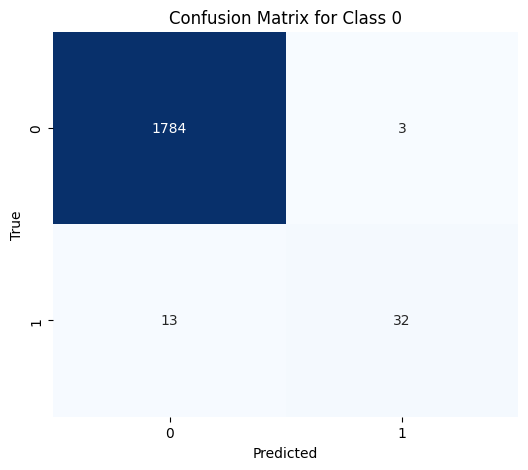

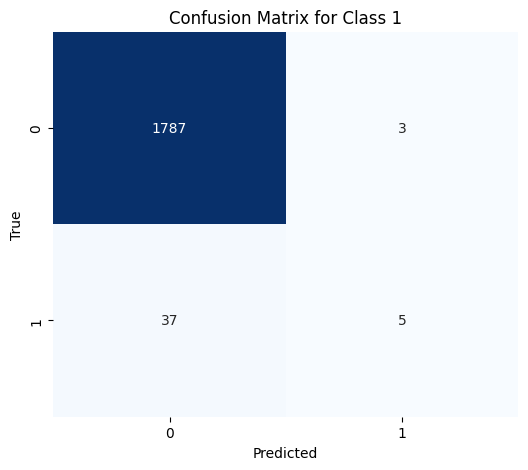

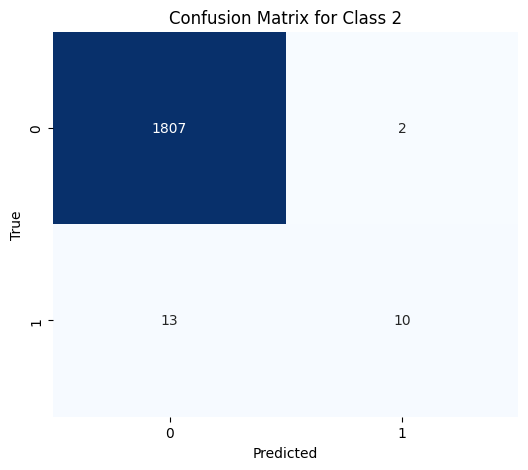

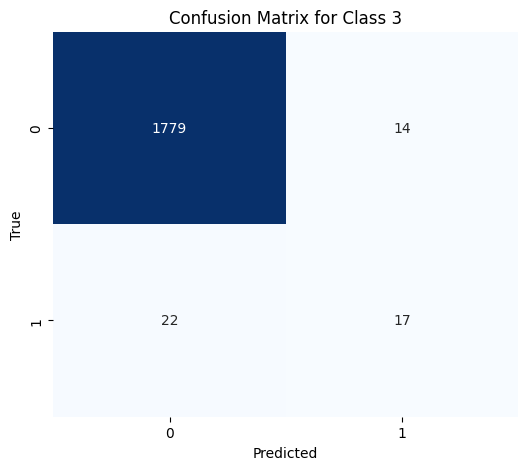

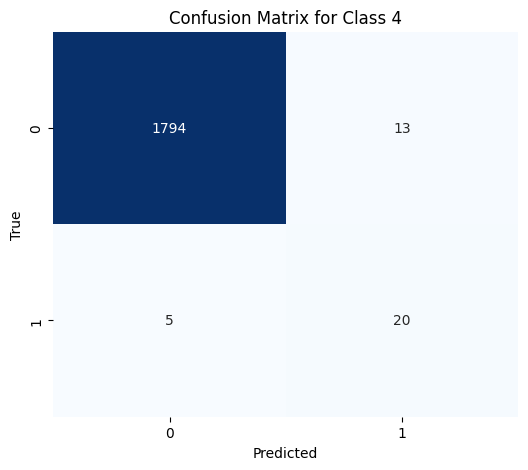

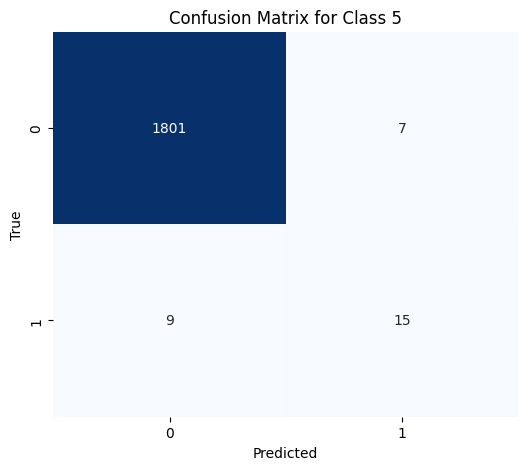

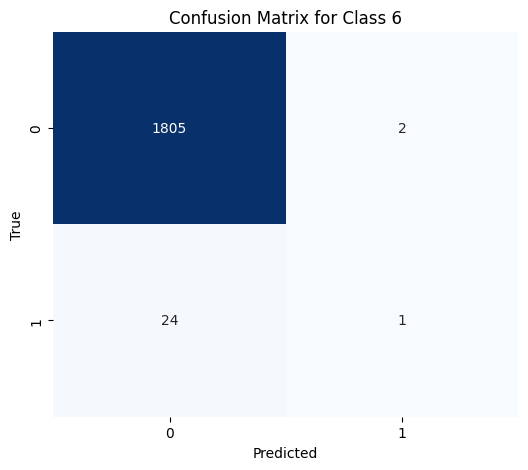

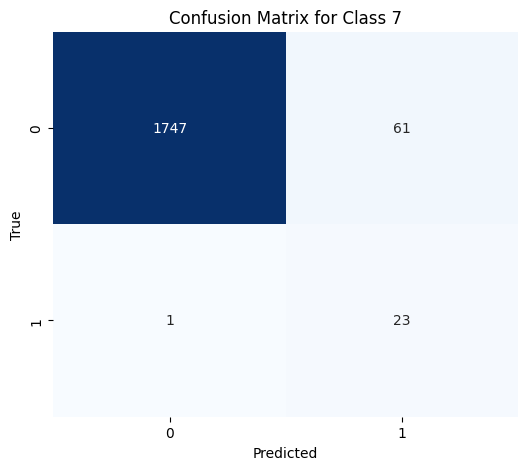

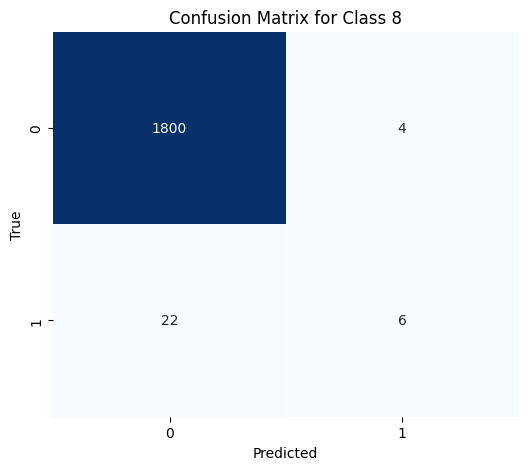

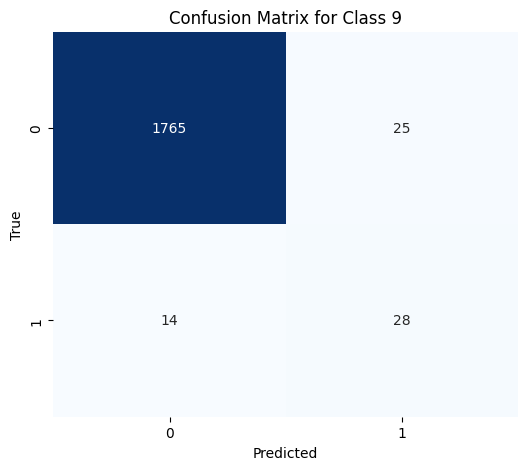

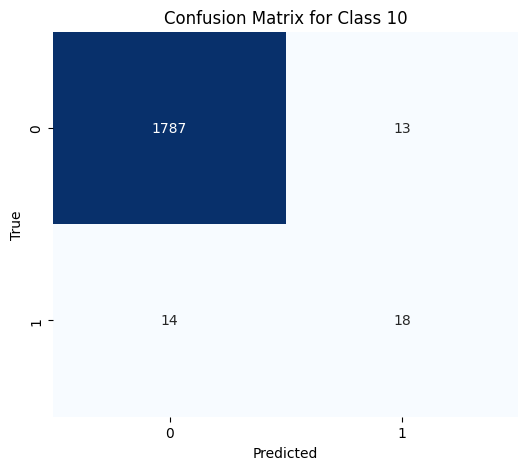

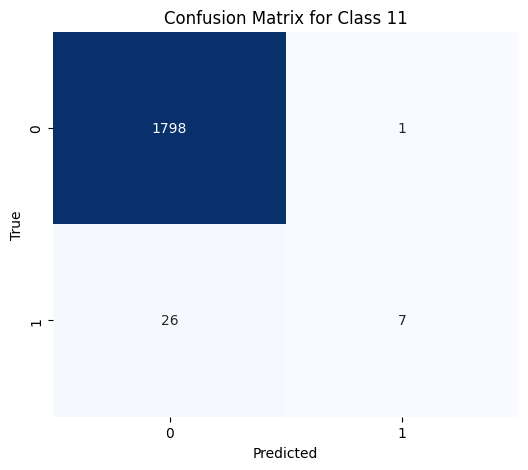

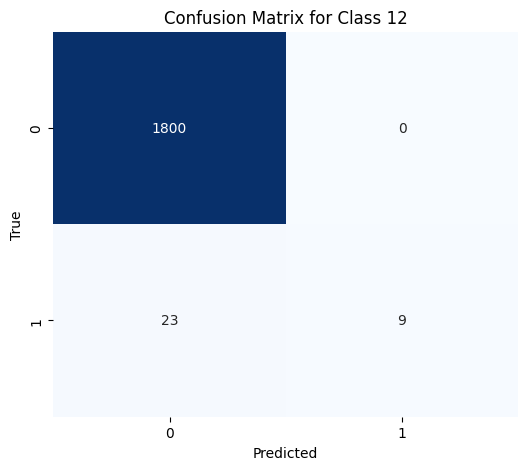

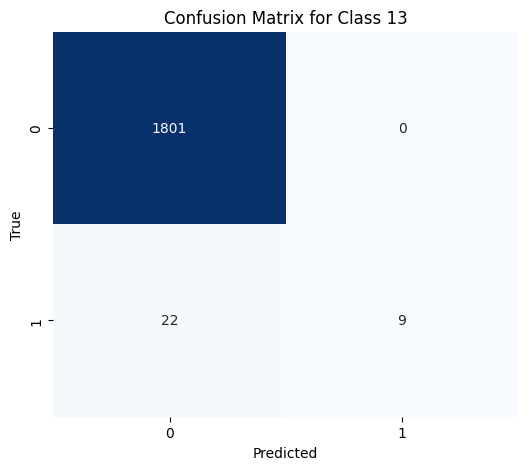

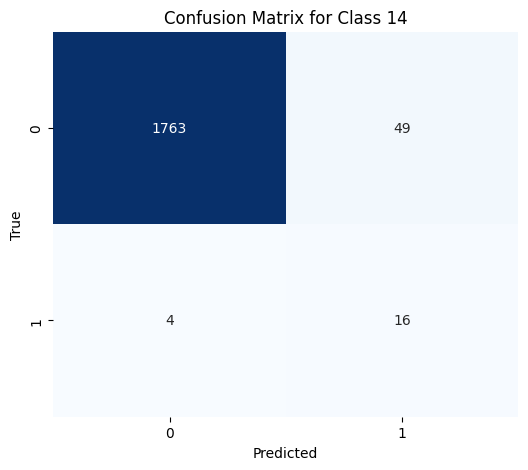

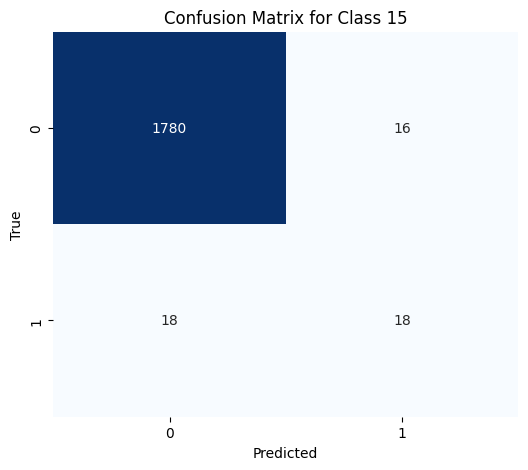

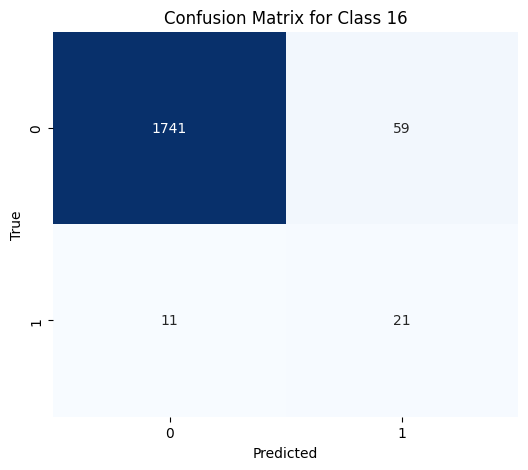

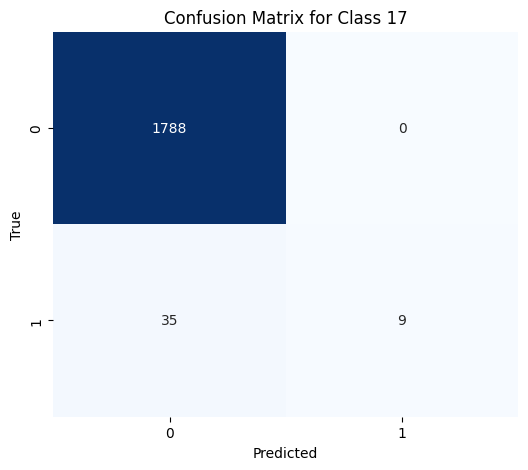

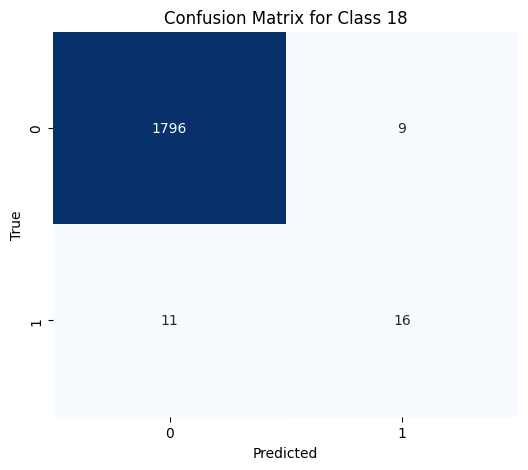

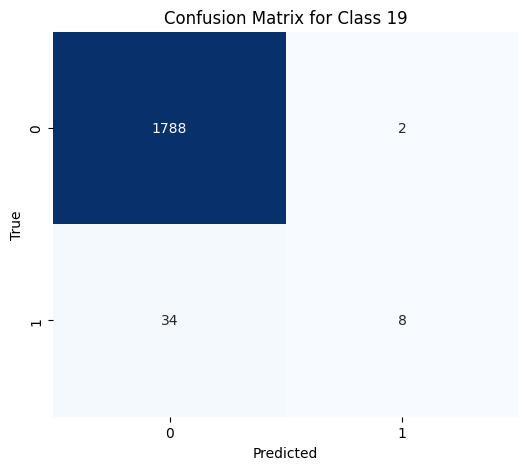

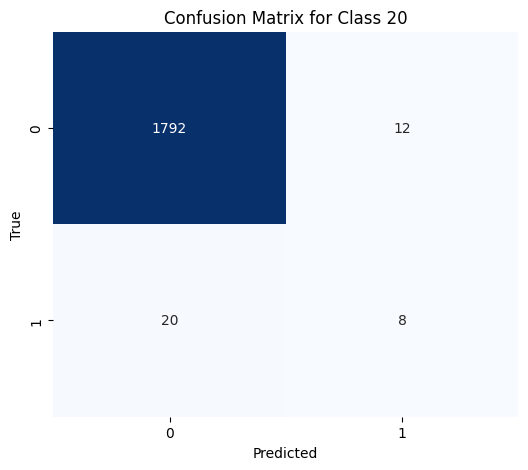

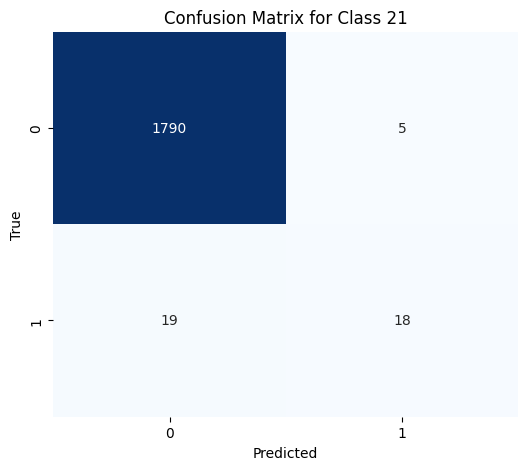

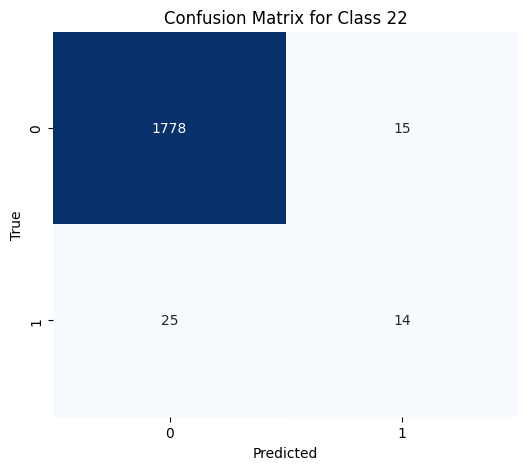

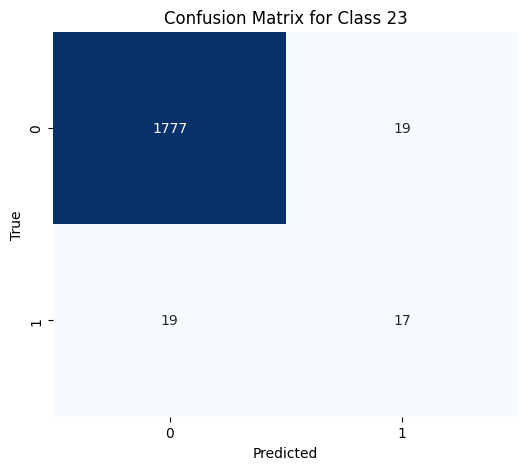

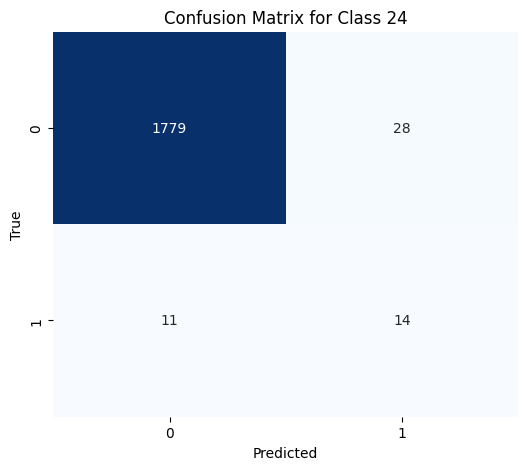

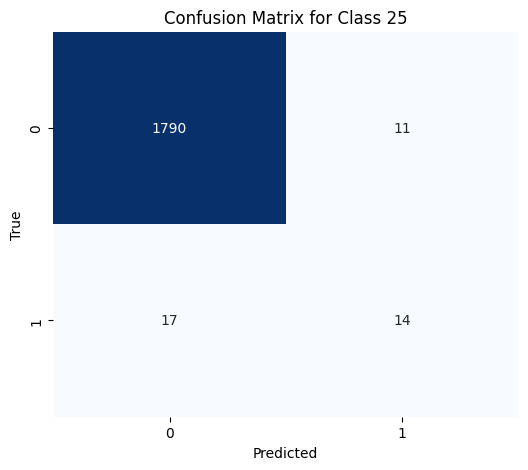

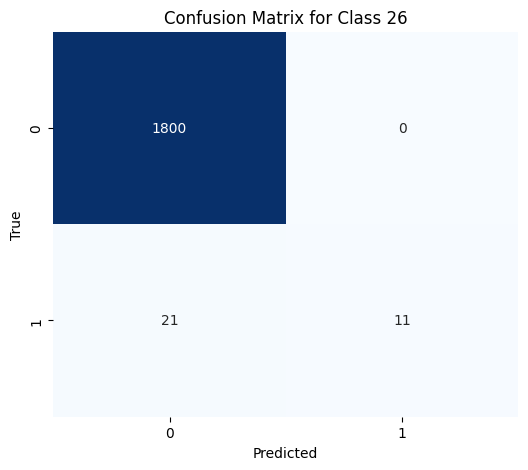

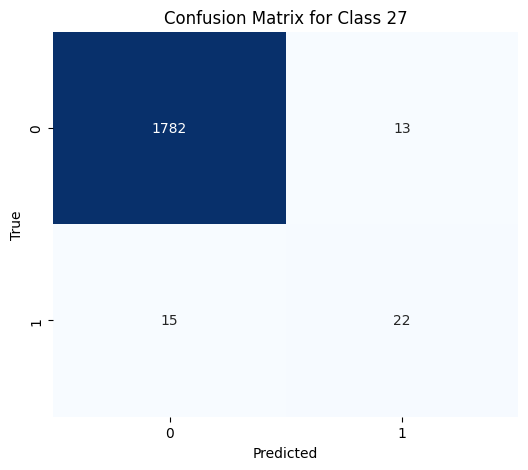

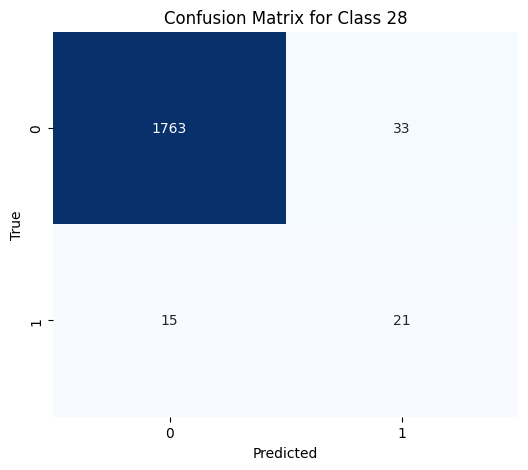

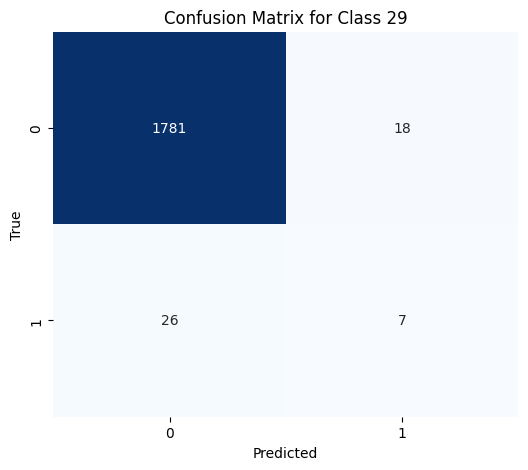

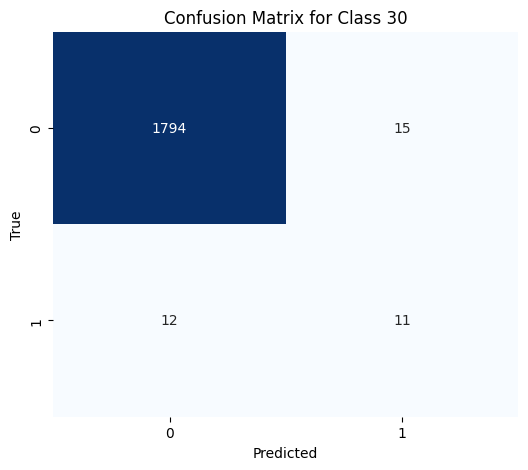

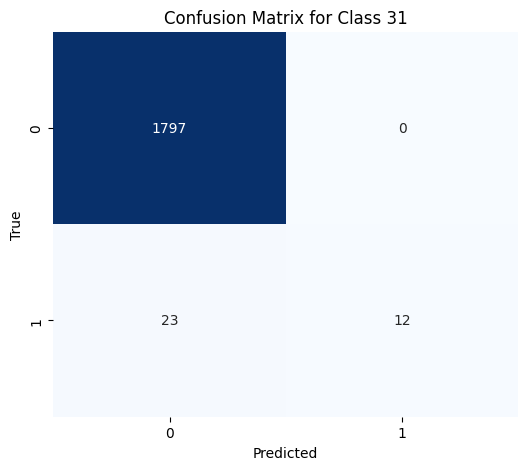

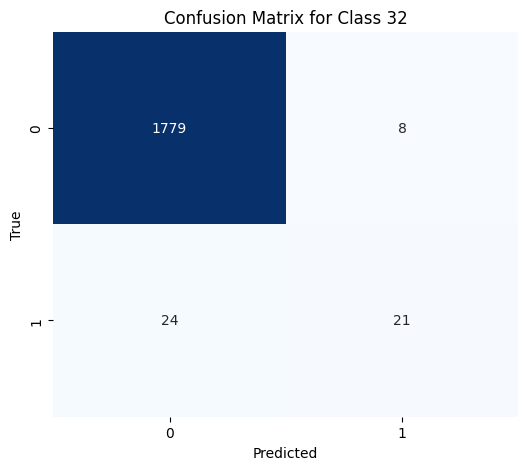

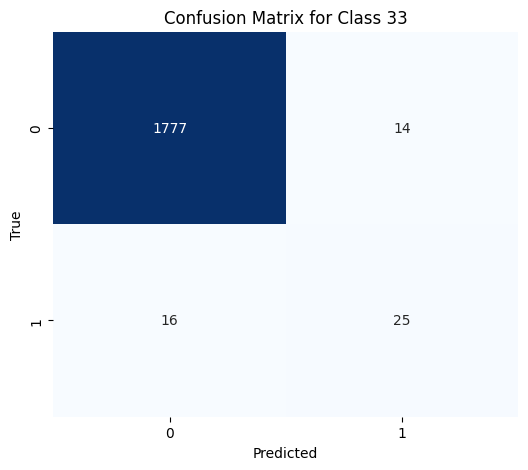

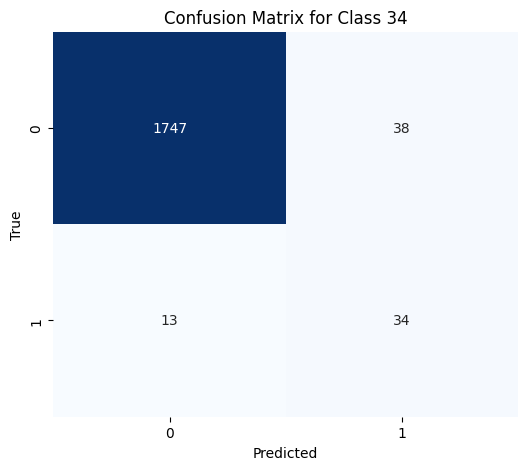

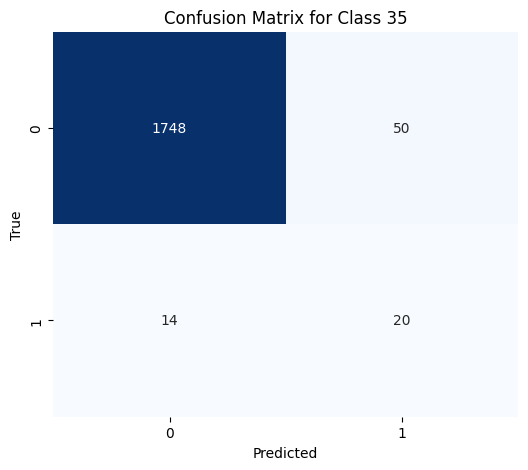

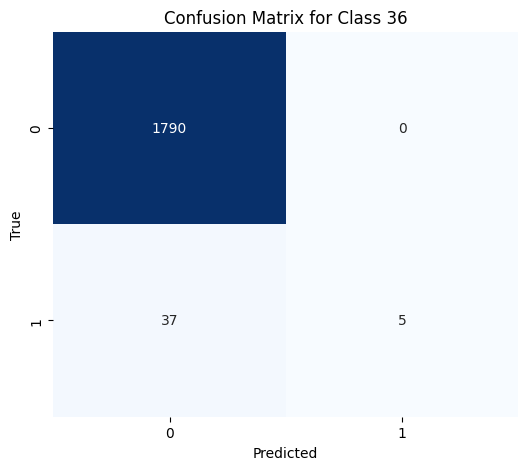

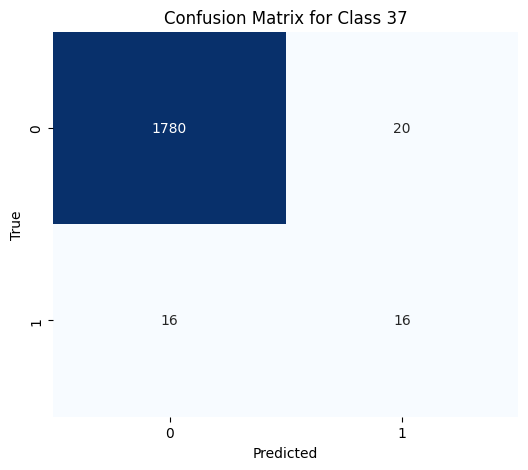

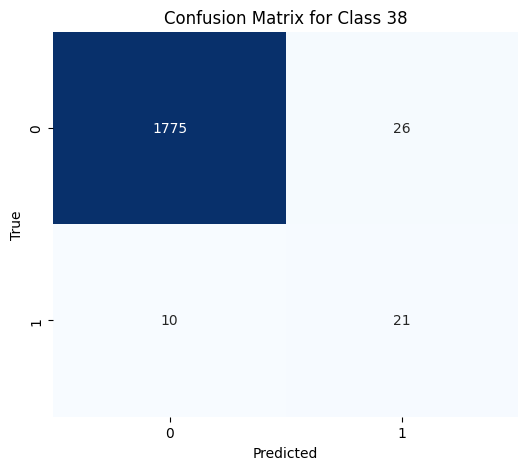

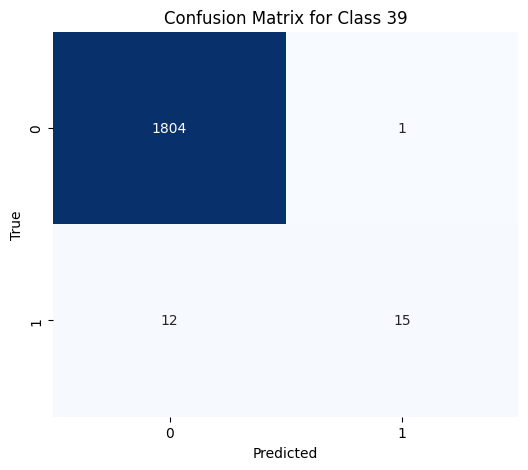

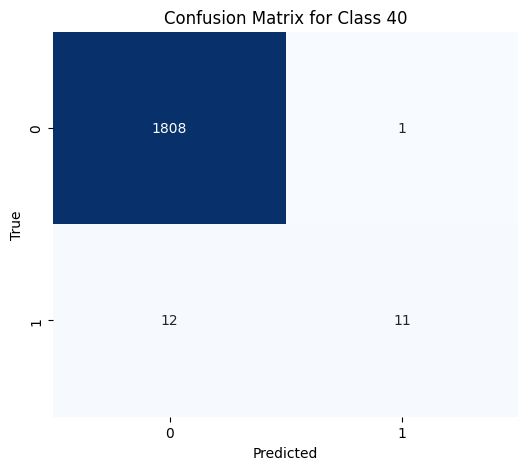

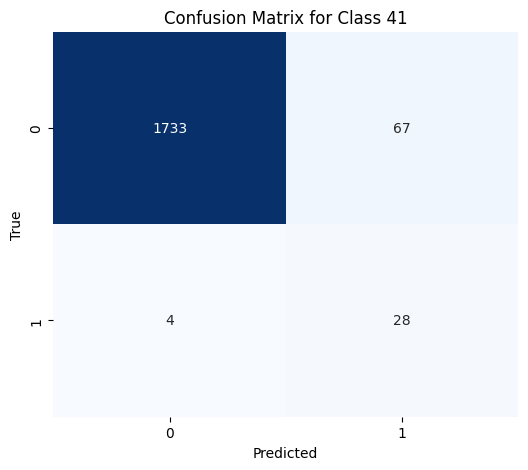

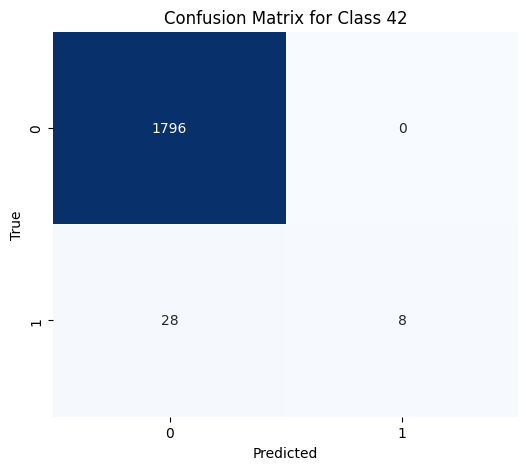

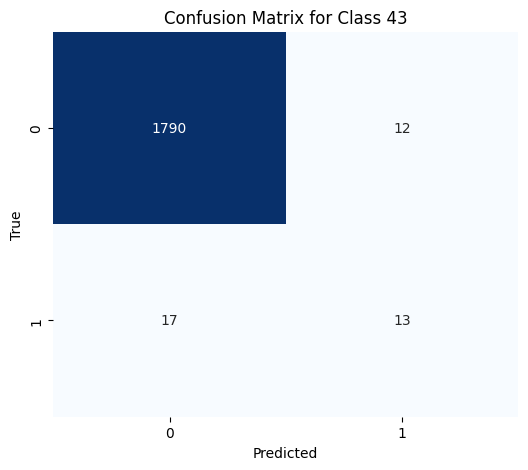

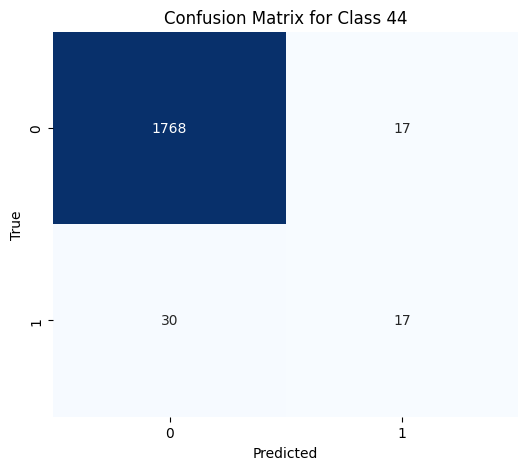

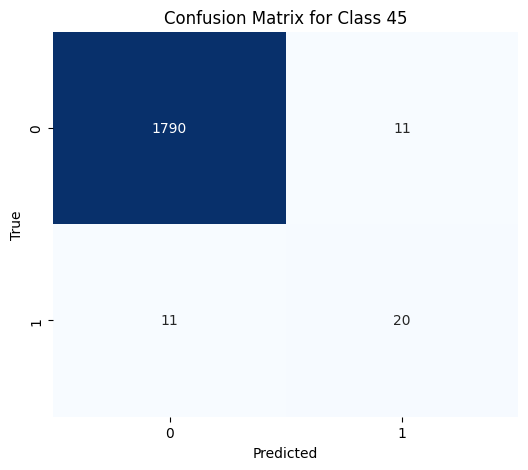

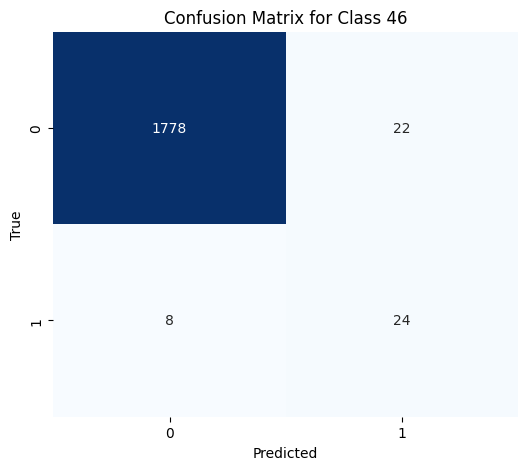

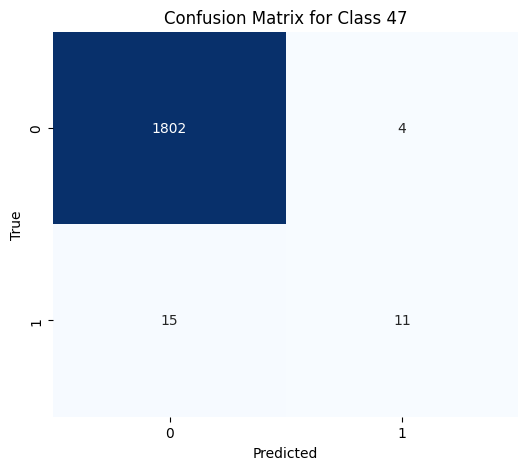

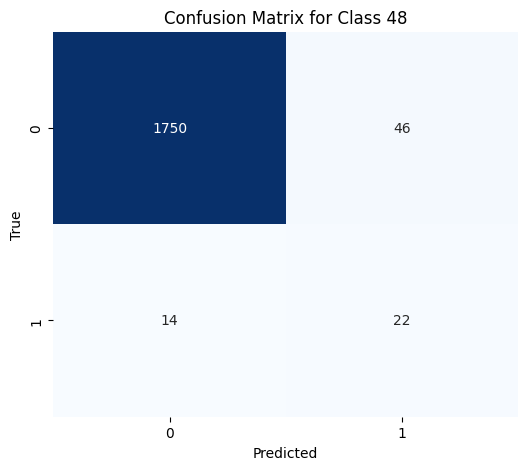

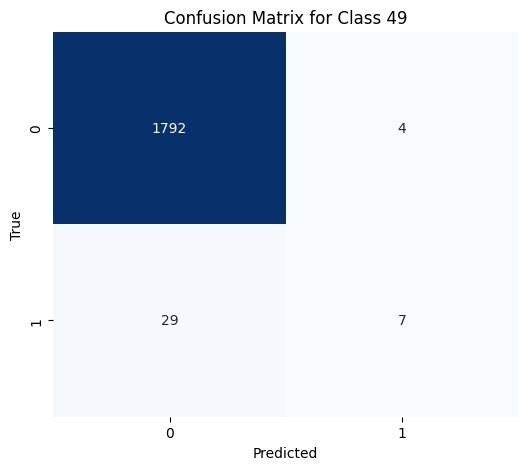

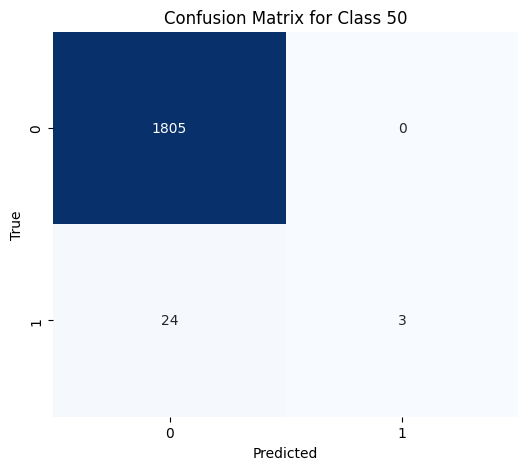

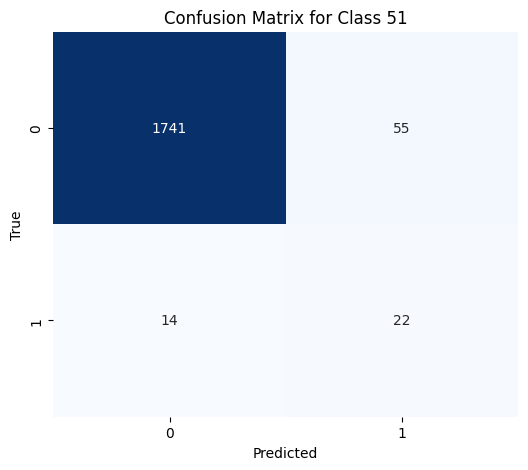

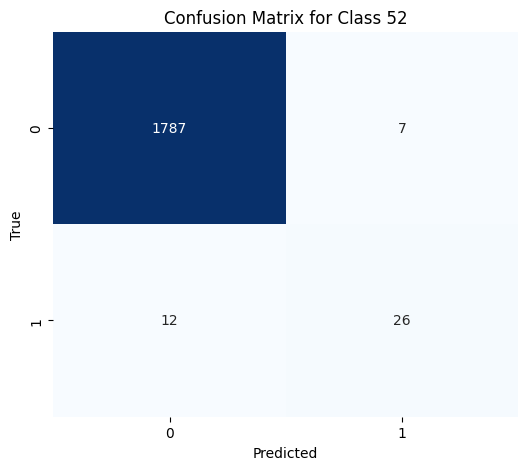

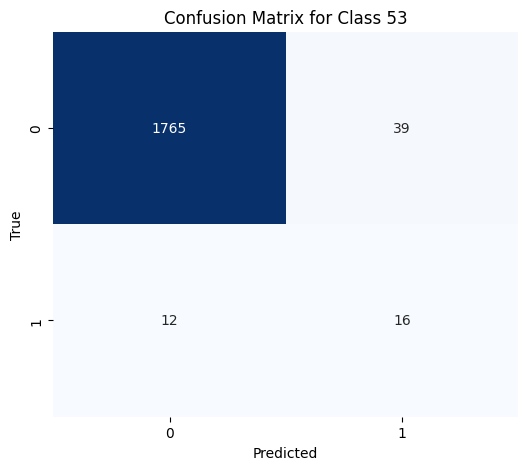

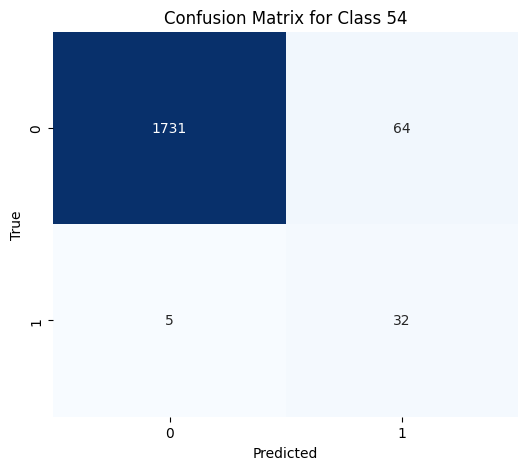

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# List of classes
classes = np.unique(y_test)

# Loop through each class and plot a binary confusion matrix
for class_idx, class_label in enumerate(classes):
    # Binarize the true and predicted labels for the current class
    y_test_binary = (y_test == class_label).astype(int)
    y_pred_binary = (y_pred_classes == class_label).astype(int)
    
    # Compute confusion matrix for the current class
    cm = confusion_matrix(y_test_binary, y_pred_binary)
    
    # Plot the confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for Class {class_label}')
    plt.show()

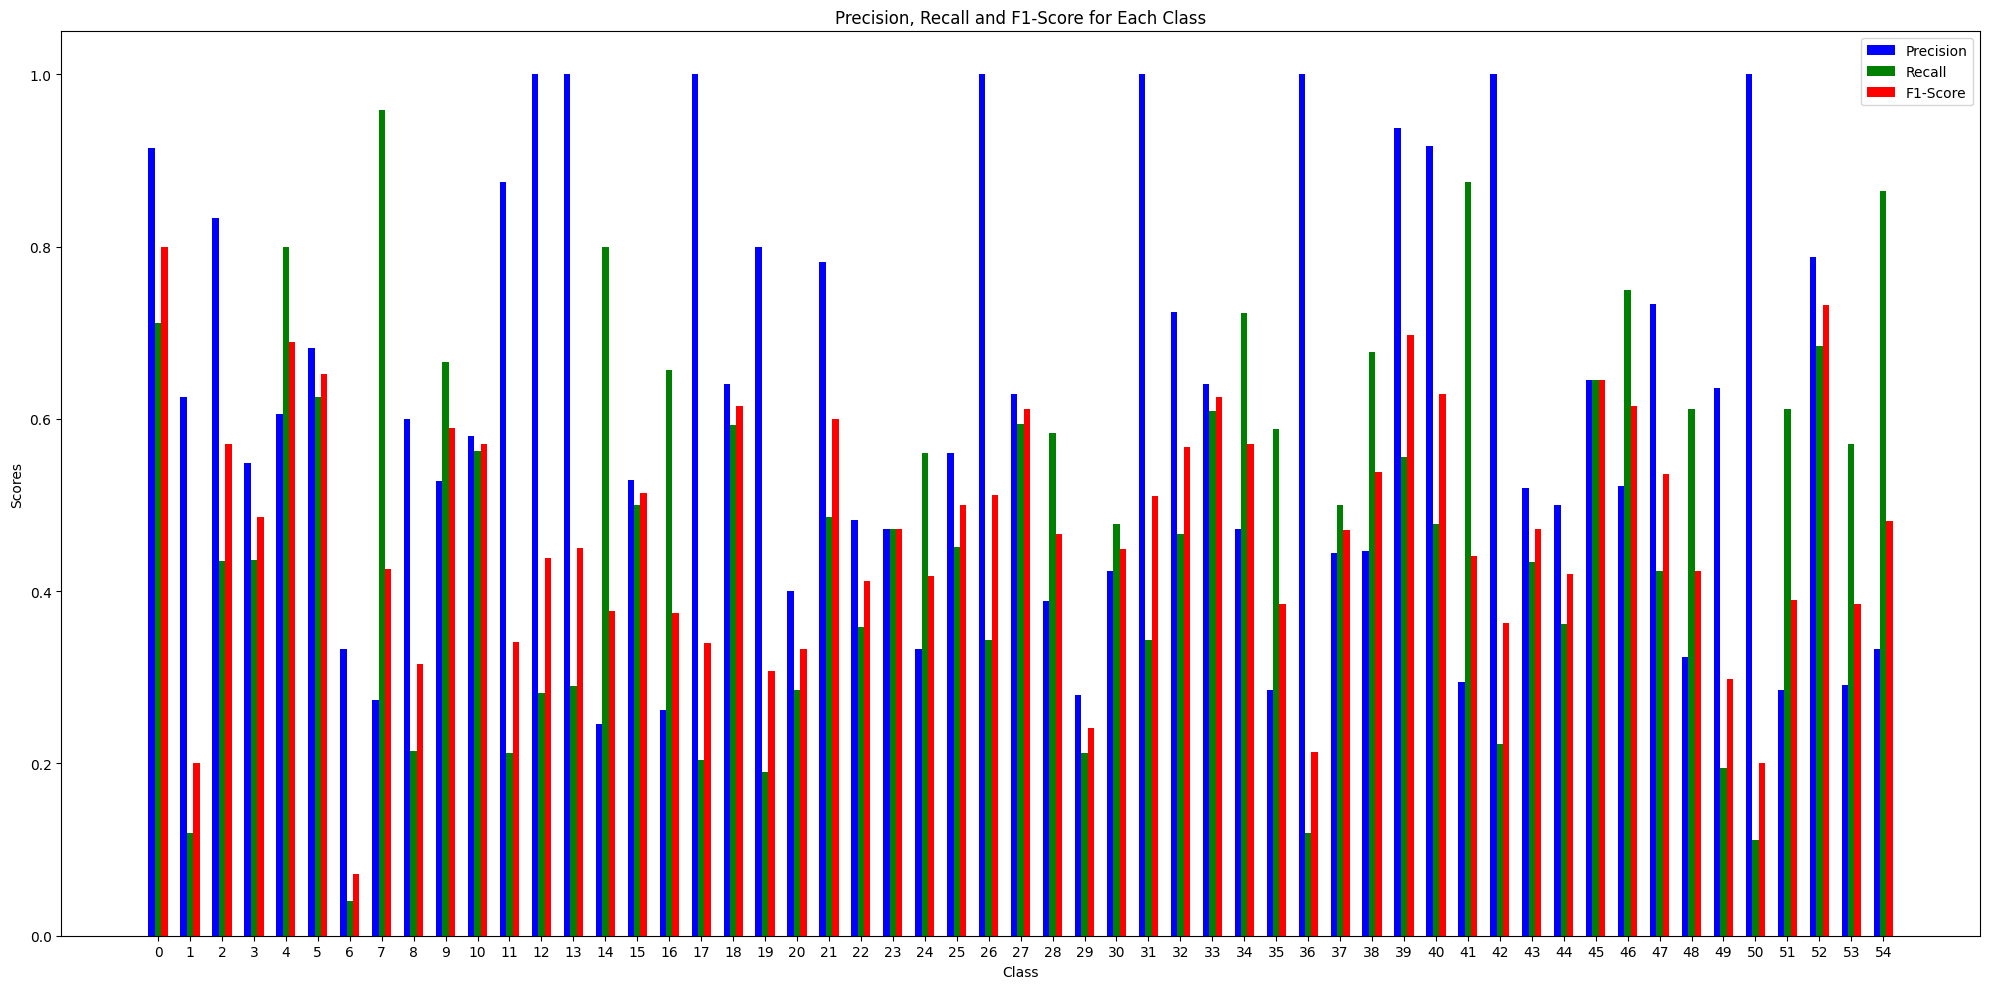

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np

# Assuming y_test are true labels and y_pred_classes are predicted labels
report = classification_report(y_test, y_pred_classes, output_dict=True)

# Extracting metrics for each class
classes = list(report.keys())[:-3]  # Exclude accuracy, macro avg, and weighted avg
precision = [report[class_name]['precision'] for class_name in classes]
recall = [report[class_name]['recall'] for class_name in classes]
f1_score = [report[class_name]['f1-score'] for class_name in classes]

# Plotting the metrics
x = np.arange(len(classes))

fig, ax = plt.subplots(figsize=(20, 10))
width = 0.2  # Bar width
ax.bar(x - width, precision, width, label='Precision', color='b')
ax.bar(x, recall, width, label='Recall', color='g')
ax.bar(x + width, f1_score, width, label='F1-Score', color='r')

# Adding labels and title
ax.set_xlabel('Class')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall and F1-Score for Each Class')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()

plt.tight_layout()
plt.show()

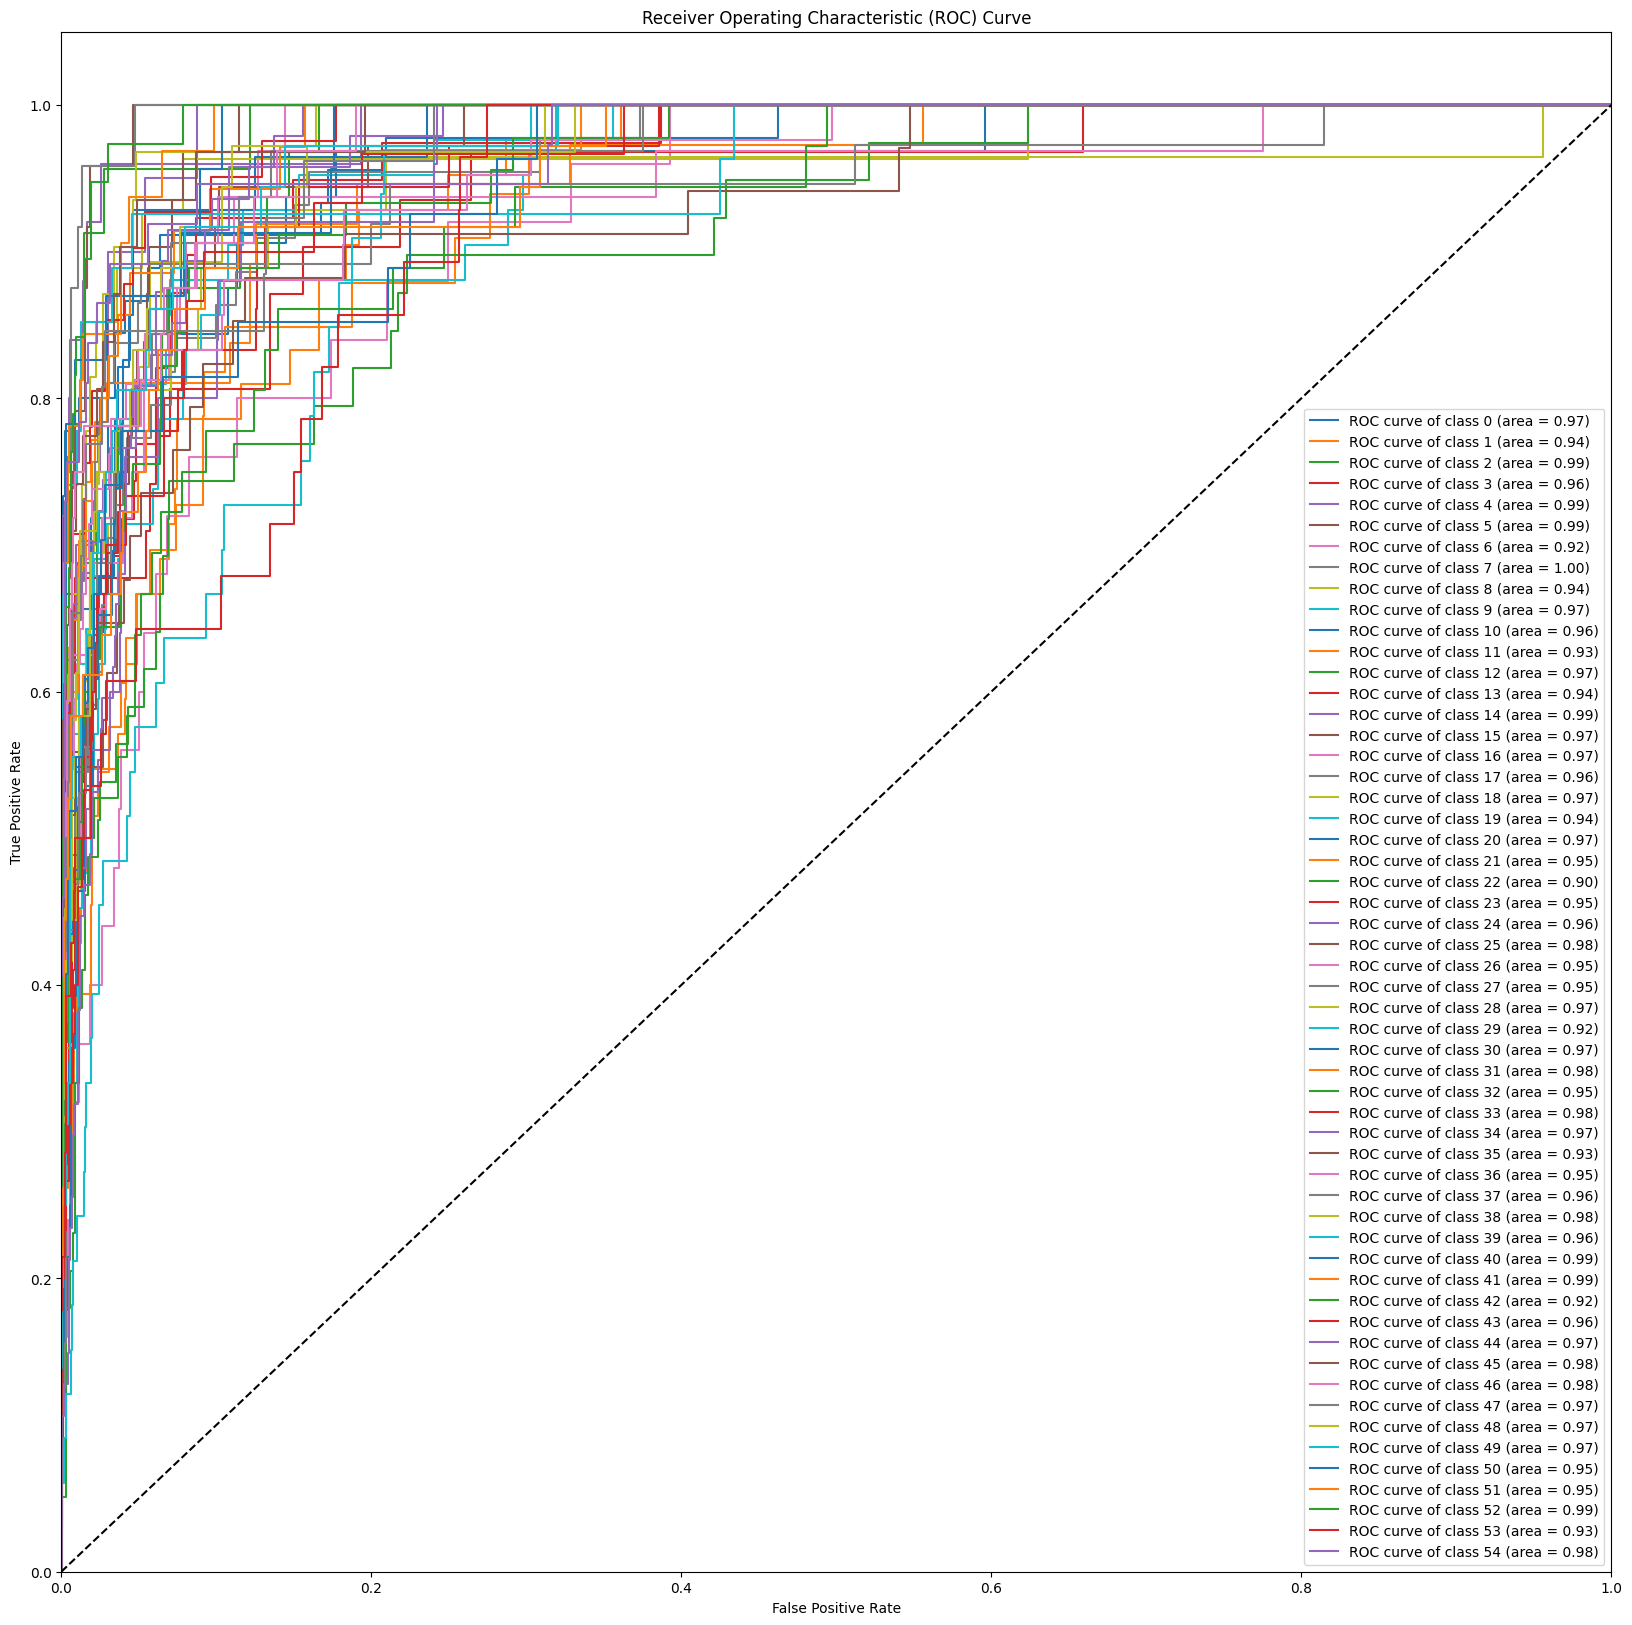

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Assuming multi-class classification
y_test_one_hot = label_binarize(y_test, classes=np.unique(y_test))
#y_pred_prob = model.predict(X_test)  # Assuming softmax output layer

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_one_hot.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(20,20))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 154ms/step


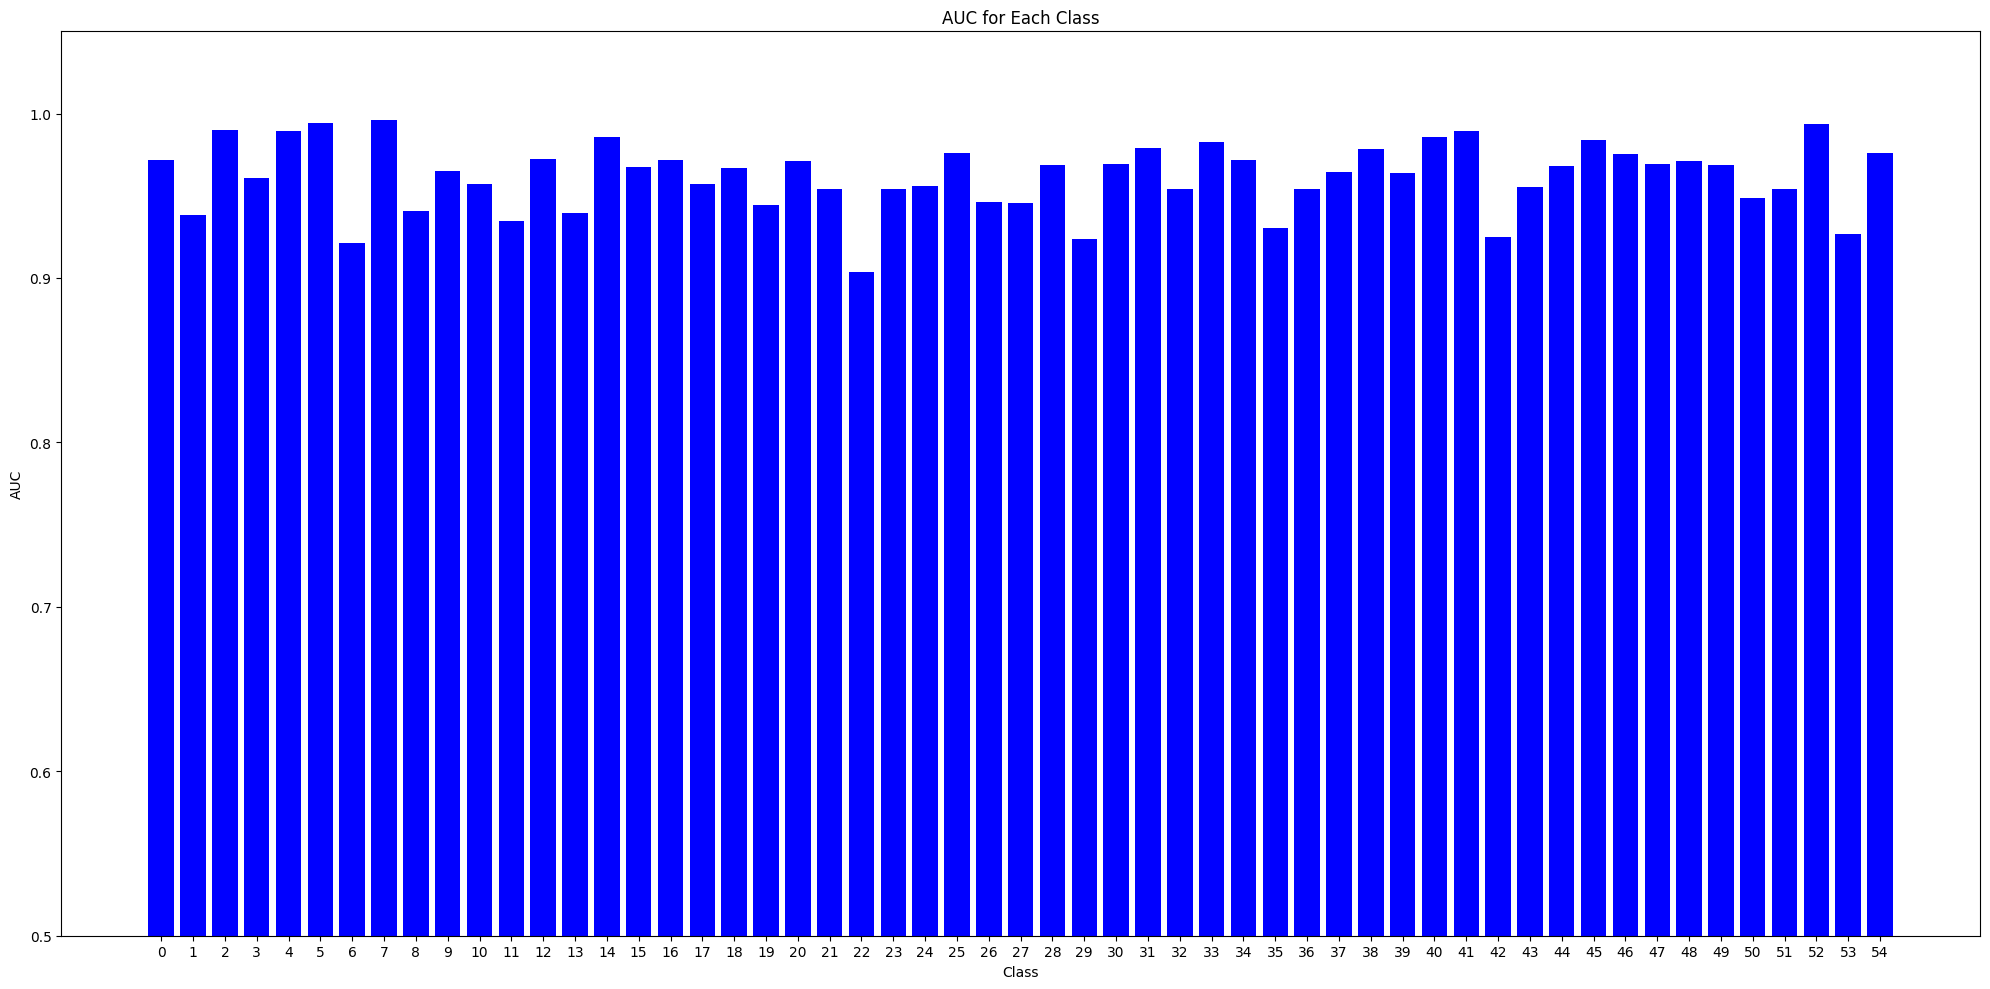

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Assuming multi-class classification
y_test_one_hot = label_binarize(y_test, classes=np.unique(y_test))
y_pred_prob = model.predict(X_test)  # Assuming softmax output layer

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_one_hot.shape[1]

# Calculate ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot AUC values for each class as a bar chart
classes = [f"{i}" for i in range(n_classes)]
auc_values = [roc_auc[i] for i in range(n_classes)]

# Plotting the AUC values as a bar chart
plt.figure(figsize=(20, 10))
plt.bar(classes, auc_values, color='blue')
plt.xlabel('Class')
plt.ylabel('AUC')
plt.title('AUC for Each Class')
plt.ylim([0.5, 1.05])  # AUC ranges from 0.5 to 1
plt.tight_layout()
plt.show()